In [221]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
plt.style.use('ggplot')

# Data preprocessing

__Change this vvvvvvv__

In [222]:
CLUSTER = "WEBSTER"

## Merge models trained on other censoring strategies into the DataFrame

In [223]:
def add_censoring_strategy_predictions(df=None, censoring_level=1, censoring_strategy="Static", keep_obs=False):
    preds_path = glob(f"../predictions/best_sweep_tgcn_cpnll_*_{censoring_strategy.lower()}_{censoring_level}/predictions_TGCN_{CLUSTER}*.csv")[0] 
    df_preds = pd.read_csv(preds_path, parse_dates=["Date"], index_col=0)

    # Because we HAD a bug of double predictions being generated
    df_preds.dropna(inplace=True)

    # Assume we have forecast horizon of 1. Then we rename the columns to something more readable
    df_preds.rename(columns={
        CLUSTER+"_1": f"Censored Observations {censoring_strategy} {censoring_level}",
        CLUSTER+"_1_pred": f"Predicted {censoring_strategy} {censoring_level}",
        f"{CLUSTER}_1_true": f"True Observations"
    }, inplace=True)

    if not keep_obs:
        df_preds = df_preds.drop(f"True Observations", axis=1)

    if df is None:
        return df_preds
    return df.merge(df_preds, on="Date")

In [224]:
df = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True)
df.head()

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations
0,2019-05-02 00:30:00,0.0,3.299242,0.0
1,2019-05-02 01:00:00,0.0,0.830811,0.0
2,2019-05-02 01:30:00,0.0,0.609476,0.0
3,2019-05-02 02:00:00,0.0,0.408683,0.0
4,2019-05-02 02:30:00,0.0,0.323562,0.0


In [225]:
df = add_censoring_strategy_predictions(df, 1, "Dynamic")
df.head()

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,Censored Observations Dynamic 1,Predicted Dynamic 1
0,2019-05-02 00:30:00,0.0,3.299242,0.0,0.0,4.177380
1,2019-05-02 01:00:00,0.0,0.830811,0.0,0.0,0.386483
2,2019-05-02 01:30:00,0.0,0.609476,0.0,0.0,0.177470
3,2019-05-02 02:00:00,0.0,0.408683,0.0,0.0,0.095260
4,2019-05-02 02:30:00,0.0,0.323562,0.0,0.0,0.091367


In [226]:
df = add_censoring_strategy_predictions(df, 2, "Static")
df.head()

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,Censored Observations Dynamic 1,Predicted Dynamic 1,Censored Observations Static 2,Predicted Static 2
0,2019-05-02 00:30:00,0.0,3.299242,0.0,0.0,4.177380,0.0,1.523421
1,2019-05-02 01:00:00,0.0,0.830811,0.0,0.0,0.386483,0.0,0.185558
2,2019-05-02 01:30:00,0.0,0.609476,0.0,0.0,0.177470,0.0,0.087021
3,2019-05-02 02:00:00,0.0,0.408683,0.0,0.0,0.095260,0.0,0.064810
4,2019-05-02 02:30:00,0.0,0.323562,0.0,0.0,0.091367,0.0,0.050276


## Merge cluster capacity data onto the DataFrame

In [227]:
plug_capacity = pd.read_csv("../data/MaximumPlugsPerCluster.csv", index_col=0, parse_dates=["StartDate", "EndDate"])
plug_capacity = plug_capacity[['StartDate', 'EndDate', 'Cluster', 'No. Plugs per Hub']]
plug_capacity = plug_capacity[plug_capacity.Cluster != 'SHERMAN']
plug_capacity = plug_capacity[plug_capacity.Cluster == CLUSTER]
plug_capacity.head()

,StartDate,EndDate,Cluster,No. Plugs per Hub
14,2015-07-29 13:59:00,2015-07-29 15:51:00,WEBSTER,2.0
16,2015-07-29 16:53:00,2016-01-14 10:28:00,WEBSTER,4.0
20,2016-01-14 13:22:00,2016-01-14 13:45:00,WEBSTER,6.0


In [228]:
# For each cluster, set the last occurence's EndDate to be the last date in the dataset
clusters = plug_capacity['Cluster'].unique()
last_date = df['Date'].max()

# Update the last occurrence's EndDate for each cluster
for cluster in clusters:
    last_occurrence_index = plug_capacity[plug_capacity['Cluster'] == cluster].index[-1]
    plug_capacity.loc[last_occurrence_index, 'EndDate'] = last_date
plug_capacity.head()

,StartDate,EndDate,Cluster,No. Plugs per Hub
14,2015-07-29 13:59:00,2015-07-29 15:51:00,WEBSTER,2.0
16,2015-07-29 16:53:00,2016-01-14 10:28:00,WEBSTER,4.0
20,2016-01-14 13:22:00,2019-06-29 23:30:00,WEBSTER,6.0


In [229]:
# Create a new DataFrame with a daily date range
start_date = plug_capacity['StartDate'].min()
end_date = plug_capacity['EndDate'].max()
daily_dates = pd.date_range(start_date, end_date, freq='D')
daily_df = pd.DataFrame({'Date': daily_dates})

# Merge the original DataFrame with the new DataFrame
merged_df = pd.merge_asof(daily_df, plug_capacity, left_on='Date', right_on='StartDate', direction='forward')

# Forward fill the missing values in the 'Cluster' and 'No. Plugs per Hub' columns
merged_df[['Cluster', 'No. Plugs per Hub']] = merged_df[['Cluster', 'No. Plugs per Hub']].ffill()

# Fill the remaining NaN values in the 'No. Plugs per Hub' column with the first available value (backwards fill)
merged_df['No. Plugs per Hub'] = merged_df['No. Plugs per Hub'].bfill()

# Drop unnecessary columns
result_df = merged_df.drop(['StartDate', 'EndDate'], axis=1)
result_df = result_df[result_df.Cluster == CLUSTER]
result_df

,Date,Cluster,No. Plugs per Hub
0,2015-07-29 13:59:00,WEBSTER,2.0
1,2015-07-30 13:59:00,WEBSTER,6.0
2,2015-07-31 13:59:00,WEBSTER,6.0
3,2015-08-01 13:59:00,WEBSTER,6.0
4,2015-08-02 13:59:00,WEBSTER,6.0
...,...,...,...
1427,2019-06-25 13:59:00,WEBSTER,6.0
1428,2019-06-26 13:59:00,WEBSTER,6.0
1429,2019-06-27 13:59:00,WEBSTER,6.0
1430,2019-06-28 13:59:00,WEBSTER,6.0


Merge cluster capacities onto the prediction dataframe

In [230]:
df = pd.merge_asof(df, result_df, on="Date", direction="nearest")
df.head(-10)

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,Censored Observations Dynamic 1,Predicted Dynamic 1,Censored Observations Static 2,Predicted Static 2,Cluster,No. Plugs per Hub
0,2019-05-02 00:30:00,0.0,3.299242,0.0,0.0,4.177380,0.0,1.523421,WEBSTER,6.0
1,2019-05-02 01:00:00,0.0,0.830811,0.0,0.0,0.386483,0.0,0.185558,WEBSTER,6.0
2,2019-05-02 01:30:00,0.0,0.609476,0.0,0.0,0.177470,0.0,0.087021,WEBSTER,6.0
3,2019-05-02 02:00:00,0.0,0.408683,0.0,0.0,0.095260,0.0,0.064810,WEBSTER,6.0
4,2019-05-02 02:30:00,0.0,0.323562,0.0,0.0,0.091367,0.0,0.050276,WEBSTER,6.0
...,...,...,...,...,...,...,...,...,...,...
2816,2019-06-29 16:30:00,4.0,3.737198,6.0,5.0,3.203751,2.0,3.825294,WEBSTER,6.0
2817,2019-06-29 17:00:00,4.0,3.933399,6.0,5.0,3.372991,2.0,4.031459,WEBSTER,6.0
2818,2019-06-29 17:30:00,4.0,4.058174,6.0,5.0,3.596539,2.0,4.100322,WEBSTER,6.0
2819,2019-06-29 18:00:00,4.0,3.786338,5.0,5.0,3.520554,2.0,3.640604,WEBSTER,6.0


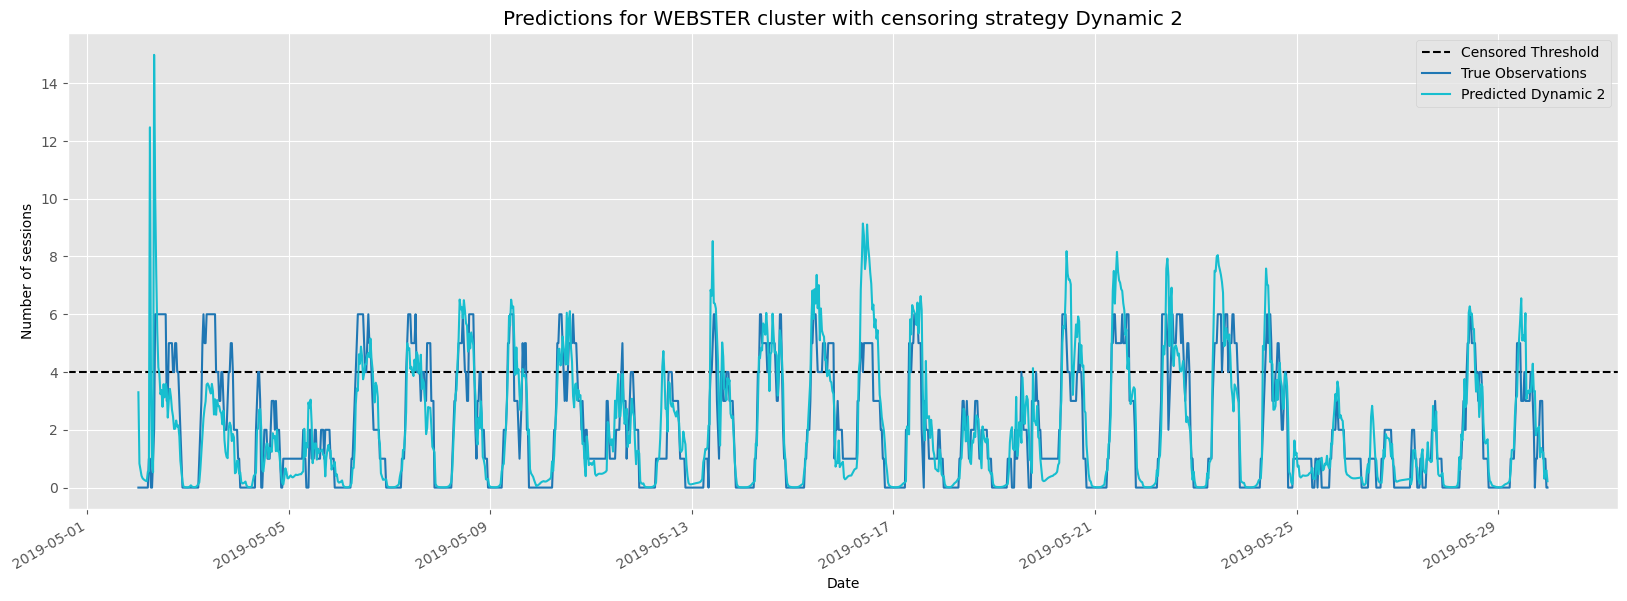

In [231]:
get_relevant_cols = lambda censoring_level, censoring_strategy: [
        'Date', 'No. Plugs per Hub', "True Observations",
        f"Censored Observations {censoring_strategy} {censoring_level}", f"Predicted {censoring_strategy} {censoring_level}"]

def plot_predictions(df, censoring_level, censoring_strategy):
    # Keep only relevant columns
    df_plot = df.copy()[get_relevant_cols(censoring_level, censoring_strategy)]
    fig, ax = plt.subplots(figsize=(20, 7))
    ax.axhline(y=df_plot[df_plot.Date < '2019-05-30'][f'Censored Observations {censoring_strategy} {censoring_level}'].max(), linestyle='--', label='Censored Threshold', color='black', )
    df_plot[df_plot.Date < '2019-05-30']\
        .drop('No. Plugs per Hub', axis=1)\
        .drop(f"Censored Observations {censoring_strategy} {censoring_level}", axis=1)\
        .plot(x="Date", ax=ax, title=f"Predictions for {CLUSTER} cluster with censoring strategy {censoring_strategy} {censoring_level}", ylabel='Number of sessions', colormap='tab10')

    # Set horizontal line at the maximum number of plugs
    ax.legend()
    plt.show()
plot_predictions(df, 2, "Dynamic")

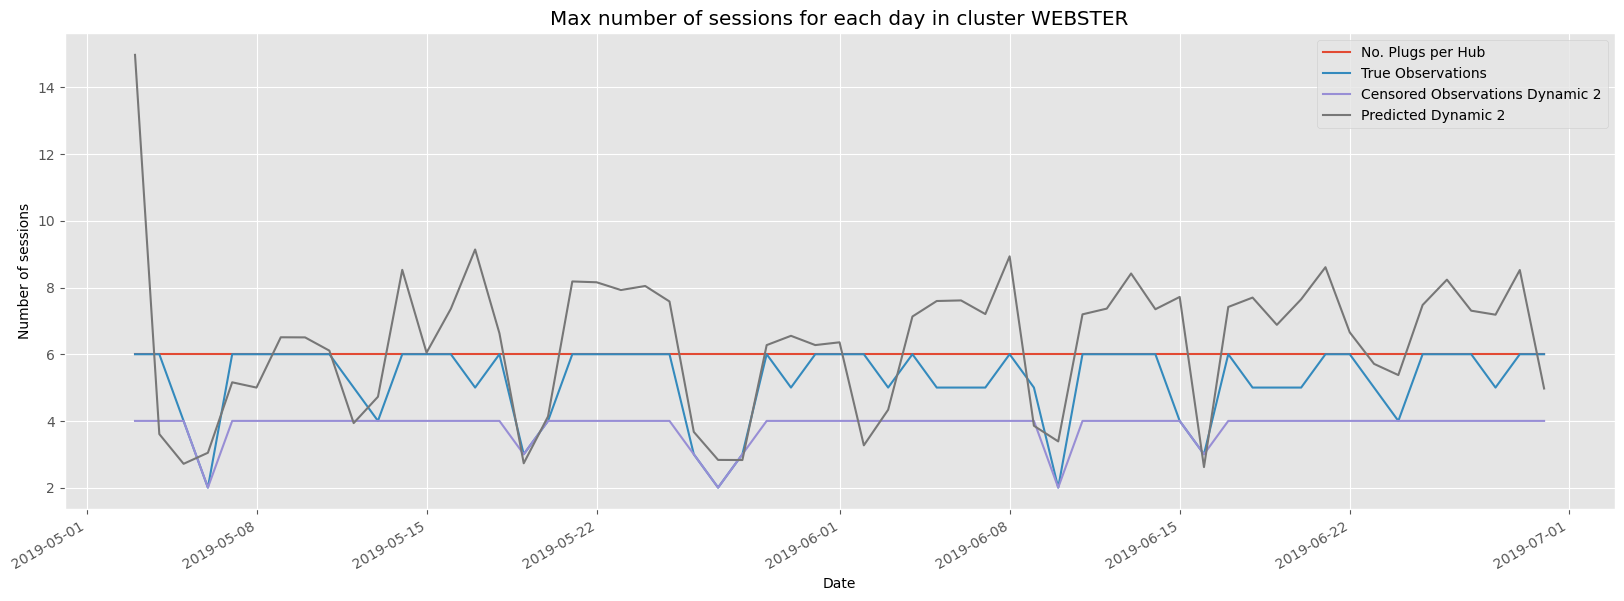

In [232]:
def plot_daily_max_sessions(df, censoring_level, censoring_strategy):
    df_plot = df.copy()[get_relevant_cols(censoring_level, censoring_strategy)]
    # Plot the highest prediction for each day, together with the highest recorded simultaneous number of sessions in a time interval
    fig, ax = plt.subplots(figsize=(20, 7))
    df_plot.groupby(df_plot["Date"].dt.date).max().plot(x="Date", ax=ax, title=f"Max number of sessions for each day in cluster {CLUSTER}")
    ax.set_title(f"Max number of sessions for each day in cluster {CLUSTER}")
    ax.set_ylabel("Number of sessions")
    plt.show()

plot_daily_max_sessions(df, 2, "Dynamic")

In [233]:
df

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,Censored Observations Dynamic 1,Predicted Dynamic 1,Censored Observations Static 2,Predicted Static 2,Cluster,No. Plugs per Hub
0,2019-05-02 00:30:00,0.0,3.299242,0.0,0.0,4.177380,0.0,1.523421,WEBSTER,6.0
1,2019-05-02 01:00:00,0.0,0.830811,0.0,0.0,0.386483,0.0,0.185558,WEBSTER,6.0
2,2019-05-02 01:30:00,0.0,0.609476,0.0,0.0,0.177470,0.0,0.087021,WEBSTER,6.0
3,2019-05-02 02:00:00,0.0,0.408683,0.0,0.0,0.095260,0.0,0.064810,WEBSTER,6.0
4,2019-05-02 02:30:00,0.0,0.323562,0.0,0.0,0.091367,0.0,0.050276,WEBSTER,6.0
...,...,...,...,...,...,...,...,...,...,...
2826,2019-06-29 21:30:00,3.0,1.590946,3.0,3.0,1.315829,2.0,0.928012,WEBSTER,6.0
2827,2019-06-29 22:00:00,2.0,1.603754,2.0,2.0,1.209252,2.0,0.978380,WEBSTER,6.0
2828,2019-06-29 22:30:00,2.0,1.004181,2.0,2.0,0.771534,2.0,1.050993,WEBSTER,6.0
2829,2019-06-29 23:00:00,1.0,0.905582,1.0,1.0,0.704283,1.0,1.047683,WEBSTER,6.0


In [236]:

def plot_utilisation_per_day(df, censoring_level, censoring_strategy):
    df_util_plot = df.copy()
    cols = get_relevant_cols(censoring_level, censoring_strategy)
    cols.remove('Date')
    # We should provide tau from the model training
    for col in cols:
        df_util_plot['tau_'+col] = df_util_plot[col].max()

    sessions_per_day = df_util_plot.groupby(df_util_plot["Date"].dt.date).sum().copy()

    # Calculate utilisation
    for col in cols:
        sessions_per_day['utilisation_'+col] = sessions_per_day[col] / sessions_per_day['No. Plugs per Hub']
    # Plot
    # drop all tau columns
    sessions_per_day = sessions_per_day[sessions_per_day.columns[sessions_per_day.columns.str.startswith('utilisation_')]]
    # remove utilisation_ from the column names
    sessions_per_day.columns = sessions_per_day.columns.str.replace('utilisation_', '')
    fig, ax = plt.subplots(figsize=(15, 5))
    sessions_per_day.plot(ax=ax)
    ax.set_title(f"Utilisation per day in cluster {CLUSTER}")
    ax.set_ylabel("Utilisation")
    sessions_per_day.head()

plot_utilisation_per_day(df, 2, "Dynamic")

TypeError: 'NoneType' object is not iterable

In [ ]:
def calculate_utility(df, max_tau):
    """ 
    Calulcate the utility for a given cluster, given predictions, censored and true values of usage, for taus from 1 - max_tau.
    """
    # 
    util_values = {level: [] for level in LEVELS}
    # calculate the utility for predicted usage, true usage and censored usage, for each tau
    for level, util_list in util_values.items():
        for tau_hypothetical in range(1, max_tau + 1):
            df_util = df.copy()
            # clip the values to the hypothetical tau (we use values from df instead of df_util to avoid clipping the values multiple times)
            df_util[level] = df[level].clip(upper=tau_hypothetical)
            # add the tau_hypothetical as a column
            df_util[f'tau_{tau_hypothetical}'] = tau_hypothetical
            # Sum the half-hourly values to get the daily values
            tmp = df_util.groupby(df_util["Date"].dt.date)[[level, f'tau_{tau_hypothetical}']].sum()
            # calculate the utility per day
            tmp['utilisation'] = (tmp[level] / tmp[f'tau_{tau_hypothetical}'])
            # add the mean utility to the list
            util_list.append(tmp['utilisation'].mean())

    return util_values
utility_values = calculate_utility(df, 12)

In [ ]:
df_utilisation = pd.DataFrame(utility_values)
df_utilisation['Capacity'] = df_utilisation.index + 1
df_utilisation

,Censored Observations,Predicted,True Observations,Capacity
0,0.659124,0.677205,0.659124,1
1,0.567124,0.582691,0.567124,2
2,0.499023,0.511650,0.499023,3
3,0.438749,0.450026,0.438749,4
4,0.350999,0.395658,0.382593,5
5,0.292499,0.347607,0.328375,6
6,0.250714,0.305583,0.281464,7
7,0.219375,0.269610,0.246281,8
8,0.195000,0.240078,0.218917,9
9,0.175500,0.216188,0.197025,10


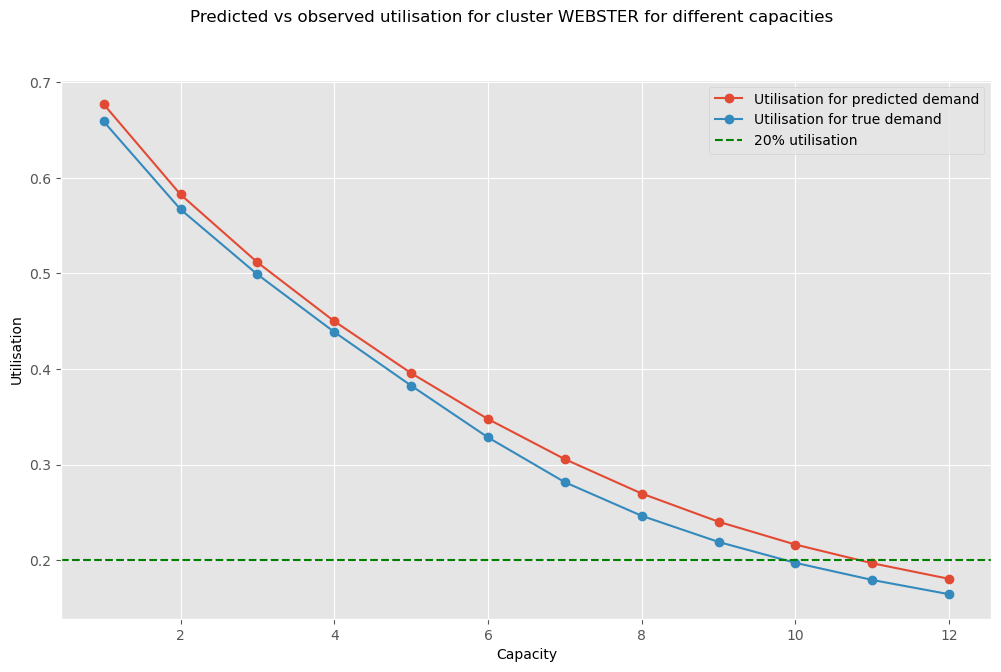

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), sharey=True)
ax.plot(df_utilisation['Capacity'], df_utilisation["Predicted"], '-o', label="Utilisation for predicted demand")

ax.plot(df_utilisation['Capacity'], df_utilisation["True Observations"], '-o', label="Utilisation for true demand")

ax.axhline(y=0.2, linestyle='--', color='g', label="20% utilisation")
ax.set_xlabel("Capacity")
ax.set_ylabel("Utilisation")
ax.yaxis.set_tick_params(labelleft=True)
ax.legend()
fig.suptitle(f"Predicted vs observed utilisation for cluster {CLUSTER} for different capacities")
plt.show()

## Utilization is key (PWC)
Once an EV-charging station is built, all costs are essentially fixed, so utilization is key to achieving efficiency. Still, even a quite low utilization is likely to result in lines at busy times. In practice, the stand-alone, fast-charger industry uses a 20% utilization as a rule of thumb. But if a charging station is utilized at more than this 20% threshold, the operator will likely look to expand capacity or, more likely, add another site nearby.